# SliceFinder Demo

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from slice_finder import SliceFinder

from ipywidgets import interact, interactive
from IPython.display import display

from bokeh.layouts import widgetbox, row
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models.widgets import DataTable, TableColumn  
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

## Toy Example: UCI Census Data Set
For the demo, we use UCI Census data set and the classification task is to predict who makes above 50k a year.

In [10]:
adult_data = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data = adult_data.dropna()

# Encode categorical features
encoders = {}
for column in adult_data.columns:
    if adult_data.dtypes[column] == np.object:
        le = LabelEncoder()
        adult_data[column] = le.fit_transform(adult_data[column])
        encoders[column] = le
        #print(column, le.classes_, le.transform(le.classes_))

X, y = adult_data[adult_data.columns.difference(["Target"])], adult_data["Target"]

# Train a model
lr = LogisticRegression()
lr.fit(X, y)

sf = SliceFinder(lr, (X, y))
metrics_all = sf.evaluate_model((X,y))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

## SliceFinder Recommendation Example

In [8]:

recommendations = sf.find_slice(k=5, epsilon=0.3, degree=3)

for s in recommendations:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('size: %s'%(s.size))

/Users/yeounoh/git/slicefinder/risk_control.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  sample_b_mean = (mu*n - np.sum(sample_a))/(n-len(sample_a))
/Users/yeounoh/git/slicefinder/risk_control.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  sample_b_var = (s**2*(n-1) - np.std(sample_a)**2*(len(sample_a)-1))/(n-len(sample_a)-1)
/Users/yeounoh/git/slicefinder/risk_control.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  sample_b_mean = (mu*n - np.sum(sample_a))/(n-len(sample_a))
/Users/yeounoh/git/slicefinder/risk_control.py:18: RuntimeWarning: invalid value encountered in double_scalars
  t /= math.sqrt( np.var(sample_a)/len(sample_a) + sample_b_var/(n-len(sample_a)) )
/Users/yeounoh/git/slicefinder/risk_control.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  sample_b_var = (s**2*(n-1) - np.std(sample_a)**2*(len(sample_a)-1))/(n-len(sample_a)-1)



Slice description:
Sex:Male 
---------------------
effect_size: 0.354867918492
size: 20380

Slice description:
Martial Status:Married-civ-spouse Married-AF-spouse 
---------------------
effect_size: 0.74539699662
size: 14086

Slice description:
Relationship:Husband Wife 
---------------------
effect_size: 0.74045503778
size: 13869

Slice description:
Occupation:Exec-managerial Prof-specialty 
---------------------
effect_size: 0.406698246447
size: 8030

Slice description:
Education:Doctorate Masters Prof-school Bachelors 
---------------------
effect_size: 0.43200932522
size: 7588


## SliceFinder User Interface with Minimum Effect Size Slider

In [15]:
slices, uninteresting = list(), list()
with open('slices.p','rb') as handle:
    slices = pickle.load(handle)
with open('uninteresting.p','rb') as handle:
    uninteresting = pickle.load(handle)  

def get_top_k_slices(candidates, min_effect_size):
    description_ = list()
    size_ = list()
    effect_size_ = list()
    for s in candidates:
        if s.effect_size < min_effect_size:
            continue
            
        description = ''
        for k, v in list(s.filters.items()):
            values = ''
            if k in encoders:
                le = encoders[k]
                for v_ in v:
                    values += '%s '%(le.inverse_transform(v_)[0])
            else:
                for v_ in sorted(v, key=lambda x: x[0]):
                    if len(v_) > 1:
                        values += '%s ~ %s'%(v_[0], v_[1])
                    else:
                        values += '%s '%(v_[0])
            description += '%s:%s '%(k, values)
        description_.append(description)
        size_.append(s.size)
        effect_size_.append(s.effect_size)
    return description_, size_, effect_size_

# load interesting slices
description_, size_, effect_size_ = get_top_k_slices(slices, 0)
    
# load uninteresting slices (candidates)
description_c, size_c, effect_size_c = get_top_k_slices(uninteresting, 0)
    
data = dict(
        description=description_,
        size=size_,
        effect_size=effect_size_,
    )
source = ColumnDataSource(data)

# scatter plot
hover = HoverTool(tooltips=[
    ("desc", "@description"),
    ("size", "@size"),
    ("effect_size", "@effect_size"),
])
TOOLS = [hover]
p = figure(tools=TOOLS, plot_width=400, plot_height=400, 
           y_axis_label='Effect Size', x_axis_label='Size', title=None)
r = p.circle('size', 'effect_size', source=source)
#show(p, notebook_handle=True)

# data table
columns = [
        TableColumn(field="description", title="Description"),
        TableColumn(field="size", title="Size"),
        TableColumn(field="effect_size", title="Effect Size"),
    ]
t = DataTable(source=r.data_source, columns=columns, width=600, height=400)

show(row(p, t), notebook_handle=True)

def update(k=10, min_eff_size=0.3):
    desc_, size_, effect_size_ = get_top_k_slices(slices+uninteresting, min_eff_size)
    #desc_a, size_a, effect_size_a = get_top_k_slices(slices, min_eff_size)
    #desc_b, size_b, effect_size_b = get_top_k_slices(uninteresting, min_eff_size)
    #desc_ = desc_a + desc_b
    #size_ = size_a + size_b
    #effect_size_ = effect_size_a + effect_size_b
    idx = sorted(range(len(size_)), key=lambda x: size_[x], reverse=True)
    r.data_source.data['description'] = np.array(desc_)[idx[:k]]
    r.data_source.data['size'] = np.array(size_)[idx[:k]]
    r.data_source.data['effect_size'] = np.array(effect_size_)[idx[:k]]
    push_notebook()
    
w = interactive(update, k=(1,30), min_eff_size=(0, 1, 0.05))
display(w)

interactive(children=(IntSlider(value=10, description='k', max=30, min=1), FloatSlider(value=0.3, description='min_eff_size', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

## Preliminary Results
Evaluate different baseline techniques as well as SliceFinder to see if they yield large problmatic slices.

In [46]:
import copy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from risk_control import effect_size
from decision_tree import DecisionTree

min_eff_size = 0.3

sf = SliceFinder(lr, (X, y))
sf_recs = [s for s in slices+uninteresting if s.effect_size >= min_eff_size]
sf_recs = sorted(sf_recs, key=lambda x: x.size, reverse=True)

In [ ]:
scaler = StandardScaler()
numeric_cols = ["Capital Gain", "Age", "fnlwgt", "Education-Num", "Capital Loss"]
X_ = copy.deepcopy(X)
X_[numeric_cols] = scaler.fit_transform(X_[numeric_cols])
y_pred = lr.predict(X)
X_mis, y_mis = X_[y != y_pred], y[y != y_pred]
reduced_data_train = PCA(n_components=2).fit_transform(X_mis)
reduced_data_test = PCA(n_components=2).fit_transform(X_)

In [ ]:
decisions = []
for x_, y_ in zip(X.as_matrix(), y.as_matrix()):
    y_p = lr.predict([x_])
    if y_p == y_:
        decisions.append(0)
    else:
        decisions.append(1)
dt = DecisionTree((X, y), lr)
dt = dt.fit(max_depth=10, min_size=100)

In [47]:
sf_k, sf_avg_sizes, sf_avg_eff_sizes = list(), list(), list()
cluster_k, cluster_avg_sizes, cluster_avg_eff_sizes = list(), list(), list()
tree_k, tree_avg_sizes, tree_avg_eff_sizes = list(), list(), list()

for k in range(1, 11):
    sf_recs_ = sf_recs[:k]
    if len(sf_recs_) == k:
        sf_k.append(k)
        sf_avg_sizes.append(np.mean([s.size for s in sf_recs_]))
        sf_avg_eff_sizes.append(np.mean([s.effect_size for s in sf_recs_]))
    
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(reduced_data_train) # train with mis-classified data
    y_predicted = kmeans.predict(reduced_data_test) # classify all data
    sizes, eff_sizes = list(), list()
    for cluster_id in np.unique(kmeans.labels_):
        X_cluster = X[np.array(y_predicted) == cluster_id]
        y_cluster = y[np.array(y_predicted) == cluster_id]
        sizes.append(len(X_cluster))
        eff_sizes.append(effect_size(sf.evaluate_model((X_cluster, y_cluster)), reference))
    cluster_k.append(k)
    cluster_avg_eff_sizes.append(np.mean(eff_sizes))
    cluster_avg_sizes.append(np.mean(sizes))
    
    dt_recs = dt.recommend_slices(k=k, min_effect_size=min_eff_size)
    if len(dt_recs) == k:
        tree_k.append(k)
        tree_avg_sizes.append(np.mean([s.size for s in dt_recs]))
        tree_avg_eff_sizes.append(np.mean([s.eff_size for s in dt_recs]))

/Users/yeounoh/git/slicefinder/risk_control.py:26: RuntimeWarning: invalid value encountered in double_scalars
  sample_b_mean = (mu*n - np.sum(sample_a))/(n-len(sample_a))


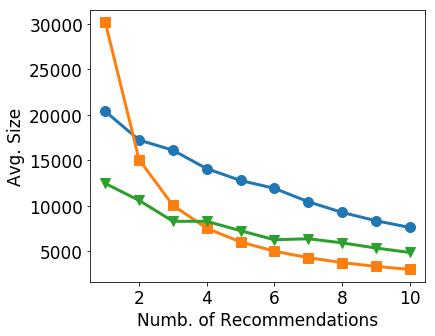

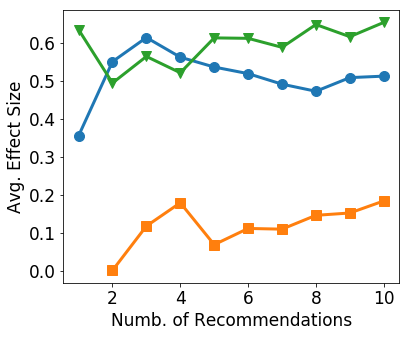

In [96]:
pickle.du

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 17})

plt.figure(1, figsize=(6,5))
ax = plt.subplot(1,1,1)
plt.plot(sf_k, sf_avg_sizes, 'o-', 
         cluster_k, cluster_avg_sizes, 's-',
         tree_k, tree_avg_sizes, 'v-', 
         linewidth=3.0, markersize=10)
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Size', fontsize=17)
plt.savefig('size.pdf')
plt.figure(2, figsize=(6,5))
ax = plt.subplot(1,1,1)
plt.plot(sf_k, sf_avg_eff_sizes, 'o-', 
         cluster_k, cluster_avg_eff_sizes, 's-',
         tree_k, tree_avg_eff_sizes, 'v-',
         linewidth=3.0, markersize=10)
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Effect Size', fontsize=17)
plt.tight_layout()
plt.savefig('effsize.pdf')
plt.show()
